In [209]:
import requests
import pandas as pd
import io
import urllib.parse

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [210]:
PERC_FAIL_LIST = [0, 5, 10, 30, 50, 90]
TIME_SLICES = list(range(5, 65, 5))
COMMUNITIES_ANALYSIS = []

In [211]:
class IoTInteractionAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df = self.df.sort_values('timestamp').reset_index(drop=True)
        
        # Parametri configurabili
        self.max_gap_seconds = 30  # Soglia per considerare interrotta un'interazione
        self.min_interaction_duration = 5  # Durata minima per considerare valida un'interazione
        
    def preprocess_interactions(self):
        """
        Calcola le durate delle interazioni e gestisce la bidirezionalità
        """
        
        # Crea coppie ordinate per evitare duplicati (A-B = B-A)
        self.df['pair'] = self.df.apply(
            lambda x: tuple(sorted([x['receiver'], x['transmitter']])), axis=1
        )
        
        interactions = []
        
        for pair in self.df['pair'].unique():
            pair_data = self.df[self.df['pair'] == pair].sort_values('timestamp')
            
            if len(pair_data) == 0:
                continue
                
            current_interaction = {
                'device_1': pair[0],
                'device_2': pair[1],
                'start_time': pair_data.iloc[0]['timestamp'],
                'detections': [pair_data.iloc[0]['timestamp']]
            }
            
            last_timestamp = pair_data.iloc[0]['timestamp']
            
            for i in range(1, len(pair_data)):
                row = pair_data.iloc[i]
                time_gap = (row['timestamp'] - last_timestamp).total_seconds()
                
                if time_gap <= self.max_gap_seconds:
                    # Continua la stessa interazione
                    current_interaction['detections'].append(row['timestamp'])
                else:
                    # Fine dell'interazione corrente
                    if len(current_interaction['detections']) > 0:
                        current_interaction['end_time'] = max(current_interaction['detections'])
                        current_interaction['duration'] = (
                            current_interaction['end_time'] - current_interaction['start_time']
                        ).total_seconds()
                        current_interaction['detection_count'] = len(current_interaction['detections'])
                        
                        if current_interaction['duration'] >= self.min_interaction_duration:
                            interactions.append(current_interaction.copy())
                    
                    # Inizia nuova interazione
                    current_interaction = {
                        'device_1': pair[0],
                        'device_2': pair[1],
                        'start_time': row['timestamp'],
                        'detections': [row['timestamp']]
                    }
                
                last_timestamp = row['timestamp']
            
            # Non dimenticare l'ultima interazione
            if len(current_interaction['detections']) > 0:
                current_interaction['end_time'] = max(current_interaction['detections'])
                current_interaction['duration'] = (
                    current_interaction['end_time'] - current_interaction['start_time']
                ).total_seconds()
                current_interaction['detection_count'] = len(current_interaction['detections'])
                
                if current_interaction['duration'] >= self.min_interaction_duration:
                    interactions.append(current_interaction)
        
        self.interactions_df = pd.DataFrame(interactions)
        return self.interactions_df
    
    
    def create_interaction_network(self):
        """
        Crea il grafo pesato delle interazioni
        """
        
        if len(self.interactions_df) == 0:
            self.network = nx.Graph()
            self.network_data = pd.DataFrame()
            return self.network
        
        # Aggrega per coppia di dispositivi
        network_data = self.interactions_df.groupby(['device_1', 'device_2']).agg({
            'duration': 'sum',
            'detection_count': 'sum',
            'start_time': 'count'  # Numero di sessioni di interazione
        }).rename(columns={'start_time': 'interaction_sessions'}).reset_index()
        
        # Crea grafo
        G = nx.Graph()
        
        # Aggiungi tutti i dispositivi come nodi (anche quelli senza interazioni)
        all_devices = set(self.df['receiver'].unique()) | set(self.df['transmitter'].unique())
        G.add_nodes_from(all_devices)
        
        # Aggiungi edges per le interazioni
        for _, row in network_data.iterrows():
            G.add_edge(
                row['device_1'], 
                row['device_2'],
                weight=row['duration'],
                detection_count=row['detection_count'],
                interaction_sessions=row['interaction_sessions'],
                avg_session_duration=row['duration'] / row['interaction_sessions']
            )
        
        self.network = G
        self.network_data = network_data
        return G
    
    
    def detect_communities(self):
        """
        Rileva comunità nella rete (gestisce grafi disconnessi)
        """
        
        if not hasattr(self, 'network'):
            self.create_interaction_network()
        
        if self.network.number_of_edges() == 0:
            communities = [frozenset([node]) for node in self.network.nodes()]
        else:
            # Algoritmo di Louvain per community detection (gestisce grafi disconnessi)
            try:
                communities = nx.community.louvain_communities(self.network, weight='weight', seed=42)
            except:
                # Fallback: usa le componenti connesse come comunità
                communities = [frozenset(component) for component in nx.connected_components(self.network)]
        
        community_dict = {}
        for i, community in enumerate(communities):
            for node in community:
                community_dict[node] = i
        
        self.communities = communities
        self.community_dict = community_dict
        return communities
    

In [212]:
def get_df_sliced(df, timeslice):
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    start_time = df["timestamp"].min()
    end_time = start_time + pd.Timedelta(minutes=timeslice)

    # Filtra il dataframe
    mask = (df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)
    return df.loc[mask]


In [213]:
for perc_fail in PERC_FAIL_LIST:
    try:
        raw_data = pd.read_csv(f"raw_data/raw_df_{perc_fail}.csv", index_col=0)
        for timeslice in TIME_SLICES:
            df_sliced = get_df_sliced(raw_data, timeslice)
            network = IoTInteractionAnalyzer(df_sliced)
            network.preprocess_interactions()
            communities = network.detect_communities()
            total_communities = len(communities)
            COMMUNITIES_ANALYSIS.append([perc_fail, timeslice, total_communities])
    except:
        pass




        

In [214]:
final_df = pd.DataFrame(COMMUNITIES_ANALYSIS, columns=["perc_fail", "timeslice", "communities"])

In [215]:
import matplotlib.pyplot as plt

def plot_communities(df, ground_truth=8):
    plt.figure(figsize=(8,5))

    # Plotta una curva per ogni perc_fail
    for perc, group in df.groupby("perc_fail"):
        plt.plot(group["timeslice"], group["communities"], marker="o", label=f"perc_fail={perc}%")

    # Aggiungi linea orizzontale della ground truth
    plt.axhline(y=ground_truth, color="r", linestyle="--", label="Ground truth")

    plt.xlabel("Timeslice (min)")
    plt.ylabel("Numero di communities")
    plt.title("Evoluzione del numero di communities rispetto alla percentuale di packet loss")
    plt.legend()
    plt.grid(True)
    plt.show()


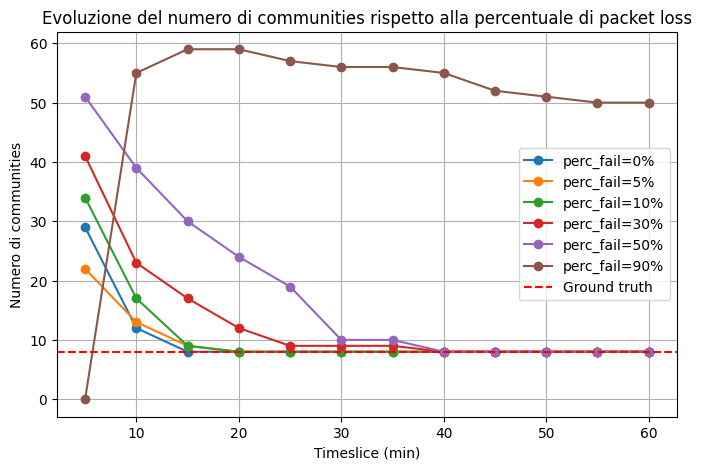

In [216]:
plot_communities(final_df, ground_truth=8)
